# <h1 style='Text-align: center;'>**4. Deep Learning**</h1>
# <h1 style='Text-align: center;'>Data Science in Engineering</h1>

`Created by: Erick Eduardo Robledo Montes`

---
---

## Libraries

In [129]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from IPython.display import clear_output
from time import sleep
from numpy import (
    zeros, 
    random, 
    dot, 
    shape, 
    reshape, 
    meshgrid, 
    linspace, 
    transpose
)

## Perceptron

In [123]:
def step(x):
    if x > 0: x = 1 
    else: x = 0
    return x

def sig(x):
    return 1/(1 + np.exp(-x))

def perceptron(x1, x2, output, lr, bias ,weights, activation):
    z = x1*weights[0] + x2*weights[1] + bias*weights[2]
    if activation == 'step': z = step(z)
    if activation == 'sig': z = sig(z)
    error = output - z
    weights[0] += error * x1 * lr
    weights[1] += error * x2 * lr
    weights[2] += error * bias * lr

### Step Activation with the AND gate

In [124]:
lr,bias,weights = 1, 1, [random.random(),random.random(),random.random()]

for i in range(50) :
   perceptron(1,1,1,lr,bias,weights,'step') 
   perceptron(1,0,0,lr,bias,weights,'step') 
   perceptron(0,1,0,lr,bias,weights,'step') 
   perceptron(0,0,0,lr,bias,weights,'step') 

x = int(input())
y = int(input())
z = x*weights[0] + y*weights[1] + bias*weights[2]
z = step(z)
print(x, "or", y, "is : ", z)

1 or 1 is :  1


### Sigmoid Activation with the AND gate

In [125]:
lr,bias,weights = 1, 1, [random.random(),random.random(),random.random()]

for i in range(50) :
   perceptron(1,1,1,lr,bias,weights,'sig') 
   perceptron(1,0,0,lr,bias,weights,'sig') 
   perceptron(0,1,0,lr,bias,weights,'sig') 
   perceptron(0,0,0,lr,bias,weights,'sig') 

x = int(input())
y = int(input())
z = x*weights[0] + y*weights[1] + bias*weights[2]
z = sig(z)
print(x, "or", y, "is : ", z)

1 or 1 is :  0.8775041857162001


## Deep NN

### NN Structure

#### Setting particular layer sizes

In [165]:
# set up all the weights and biases
NumLayers=3 # does not count input-layer (but does count output)
LayerSizes=[2,20,30,1] # input-layer,hidden-1,hidden-2,...,output-layer

# initialize random weights and biases for all layers (except input of course)
Weights=[random.uniform(low=-1,high=+1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NumLayers)]
Biases=[random.uniform(low=-1,high=+1,size=LayerSizes[j+1]) for j in range(NumLayers)]

# define the batchsize
batchsize=100

# set up all the helper variables
y_layer=[zeros([batchsize,LayerSizes[j]]) for j in range(NumLayers+1)]
df_layer=[zeros([batchsize,LayerSizes[j+1]]) for j in range(NumLayers)]
dw_layer=[zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
db_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

#### Implement backpropagation for a general fully connected network

In [168]:
def net_f_df(z): # calculate f(z) and f'(z)
    val=z*(z>0)
    return(val,z>0) # return both f and f'

def forward_step(y,w,b): # calculate values in next layer, from input y
    z=dot(y,w)+b # w=weights, b=bias vector for next layer
    return(net_f_df(z)) # apply nonlinearity and return result

def apply_net(y_in): # one forward pass through the network
    global Weights, Biases, NumLayers
    global y_layer, df_layer # for storing y-values and df/dz values
    
    y=y_in # start with input values
    y_layer[0]=y
    for j in range(NumLayers): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j]) # one step
        df_layer[j]=df # store f'(z) [needed later in backprop]
        y_layer[j+1]=y # store f(z) [also needed in backprop]        
    return(y)

def apply_net_simple(y_in): # one forward pass through the network
    # no storage for backprop (this is used for simple tests)

    y=y_in # start with input values
    y_layer[0]=y
    for j in range(NumLayers): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j]) # one step
    return(y)

def backward_step(delta,w,df): 
    # delta at layer N, of batchsize x layersize(N))
    # w between N-1 and N [layersize(N-1) x layersize(N) matrix]
    # df = df/dz at layer N-1, of batchsize x layersize(N-1)
    return( dot(delta,transpose(w))*df )

def backprop(y_target): # one backward pass through the network
    # the result will be the 'dw_layer' matrices that contain
    # the derivatives of the cost function with respect to
    # the corresponding weight
    global y_layer, df_layer, Weights, Biases, NumLayers
    global dw_layer, db_layer # dCost/dw and dCost/db (w,b=weights,biases)
    global batchsize
    
    delta=(y_layer[-1]-y_target)*df_layer[-1]
    dw_layer[-1]=dot(transpose(y_layer[-2]),delta)/batchsize
    db_layer[-1]=delta.sum(0)/batchsize
    for j in range(NumLayers-1):
        delta=backward_step(delta,Weights[-1-j],df_layer[-2-j])
        dw_layer[-2-j]=dot(transpose(y_layer[-3-j]),delta)
        db_layer[-2-j]=delta.sum(0)/batchsize

def gradient_step(eta): # update weights & biases (after backprop!)
    global dw_layer, db_layer, Weights, Biases
    
    for j in range(NumLayers):
        Weights[j]-=eta*dw_layer[j]
        Biases[j]-=eta*db_layer[j]

def train_net(y_in,y_target,eta): # one full training batch
    # y_in is an array of size batchsize x (input-layer-size)
    # y_target is an array of size batchsize x (output-layer-size)
    # eta is the stepsize for the gradient descent
    global y_out_result
    
    y_out_result=apply_net(y_in)
    backprop(y_target)
    gradient_step(eta)
    cost=((y_target-y_out_result)**2).sum()/batchsize
    return(cost)

#### Training net on one single batch

In [172]:
y_in=random.uniform(low=-1,high=+1,size=[batchsize,LayerSizes[0]])
y_target=random.uniform(low=-1,high=+1,size=[batchsize,LayerSizes[-1]])

# one training step:
train_net(y_in,y_target,.0001) # returns cost function value

0.742255730135836

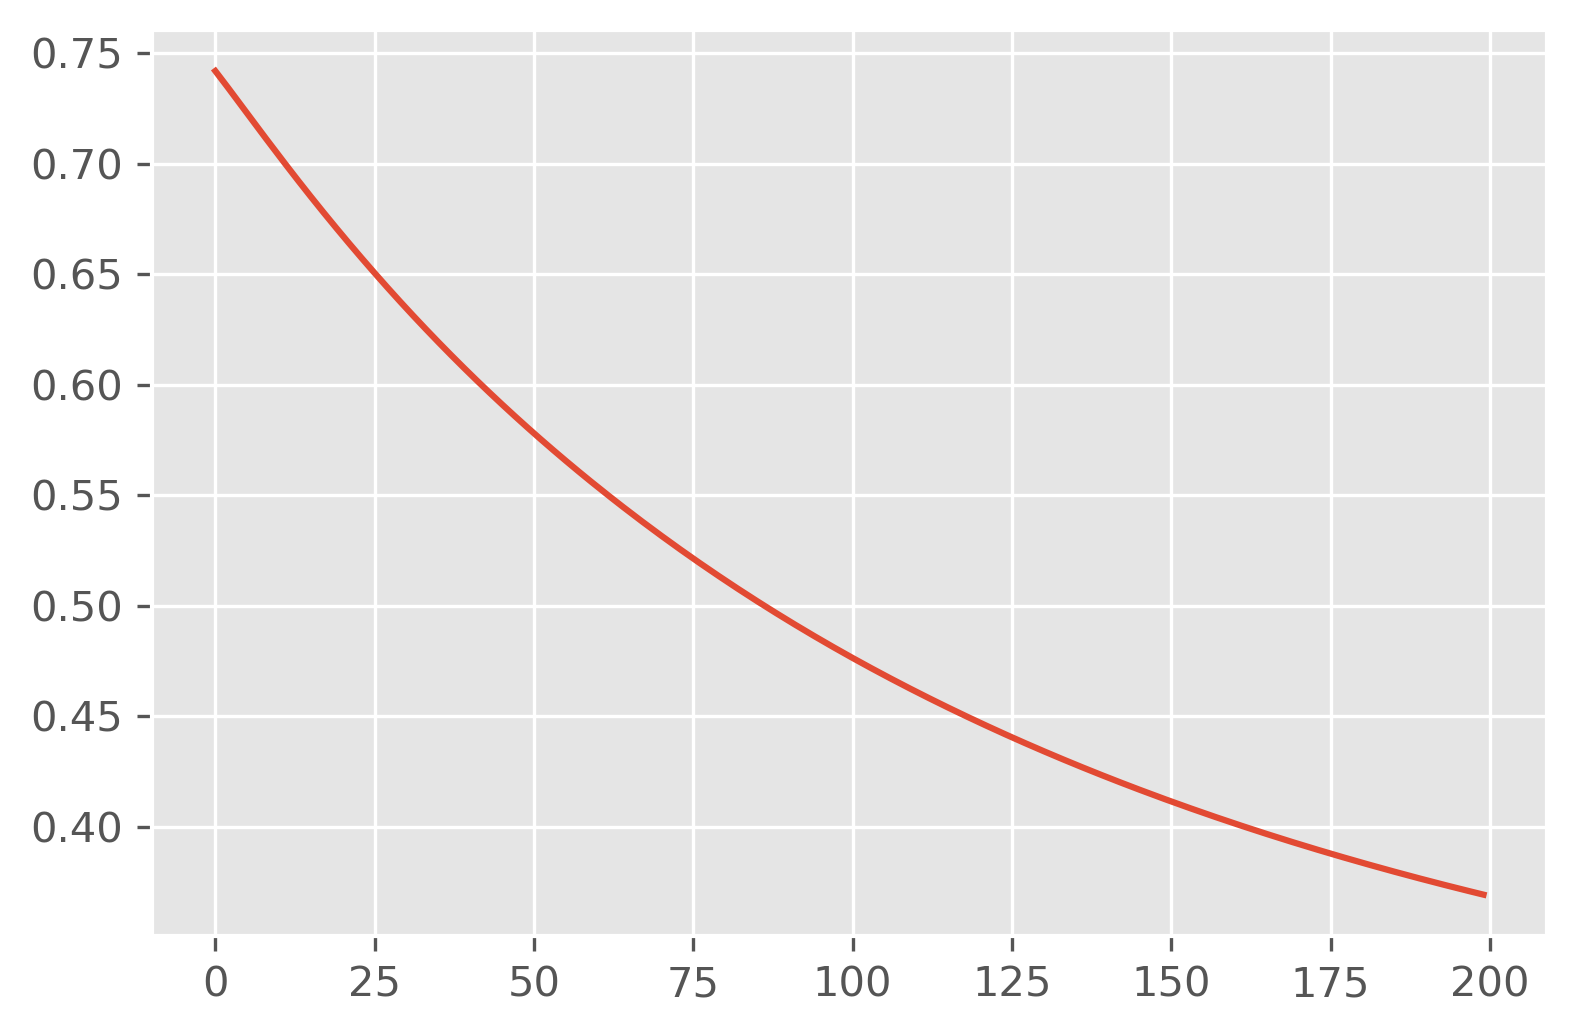

In [173]:
eta=0.001
batches=200

costs=zeros(batches) # array to store the costs

for k in range(batches):
    costs[k]=train_net(y_in,y_target,eta)

# this will show a very simple decrease, because
# we are not yet stochastically sampling inputs
# (it is always the SAME input! so the network
# only becomes good for that input)
plt.plot(costs)
plt.show()

#### Produce random batches on a 2D square function

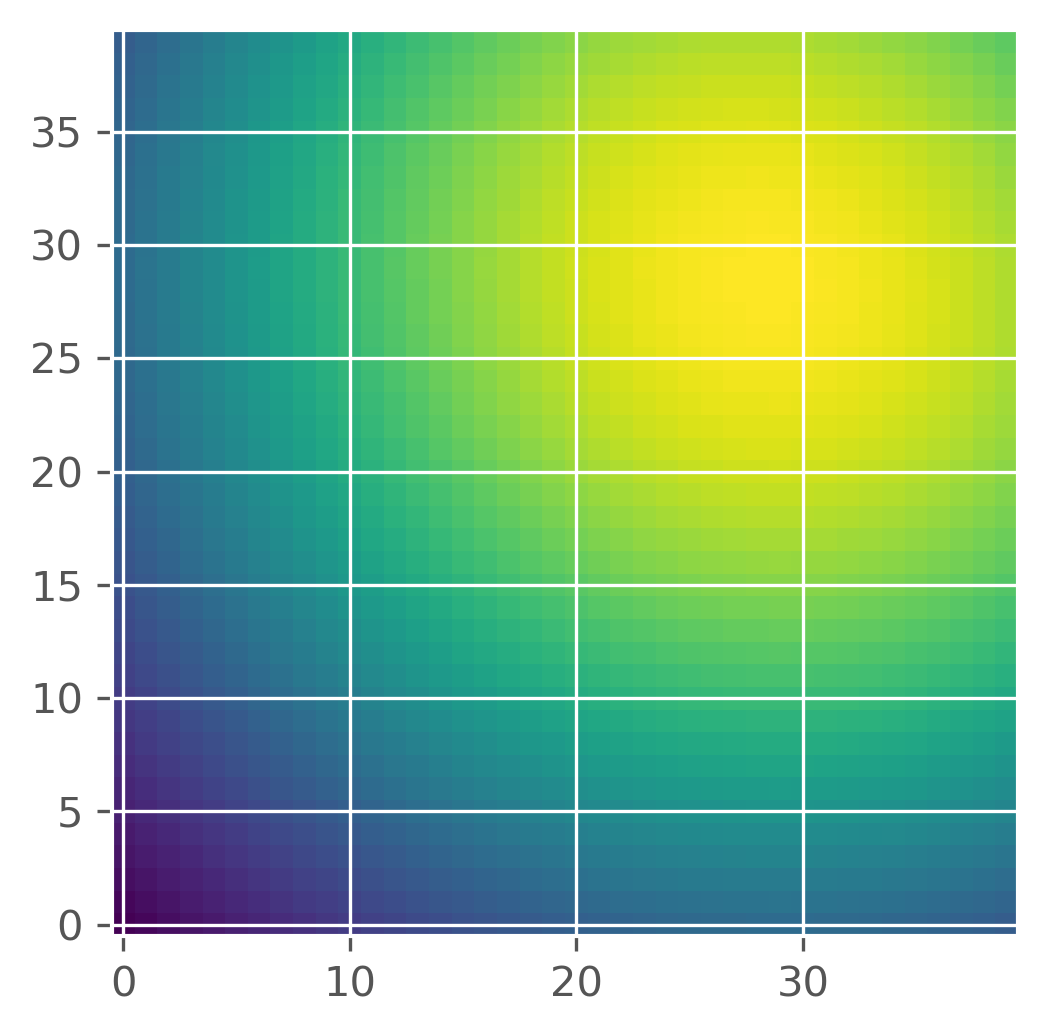

In [156]:
def my_target(x0, x1):
    exp_x = -(x0**2 + x1**2)
    new_x = x0 + x1
    return( np.exp(exp_x)*np.sqrt(new_x + 1j) )

xrange = linspace(-0.5,0.5,40)
X0,X1 = meshgrid(xrange,xrange)
plt.imshow(my_target(X0,X1).real,interpolation='nearest',origin='lower')
plt.show()

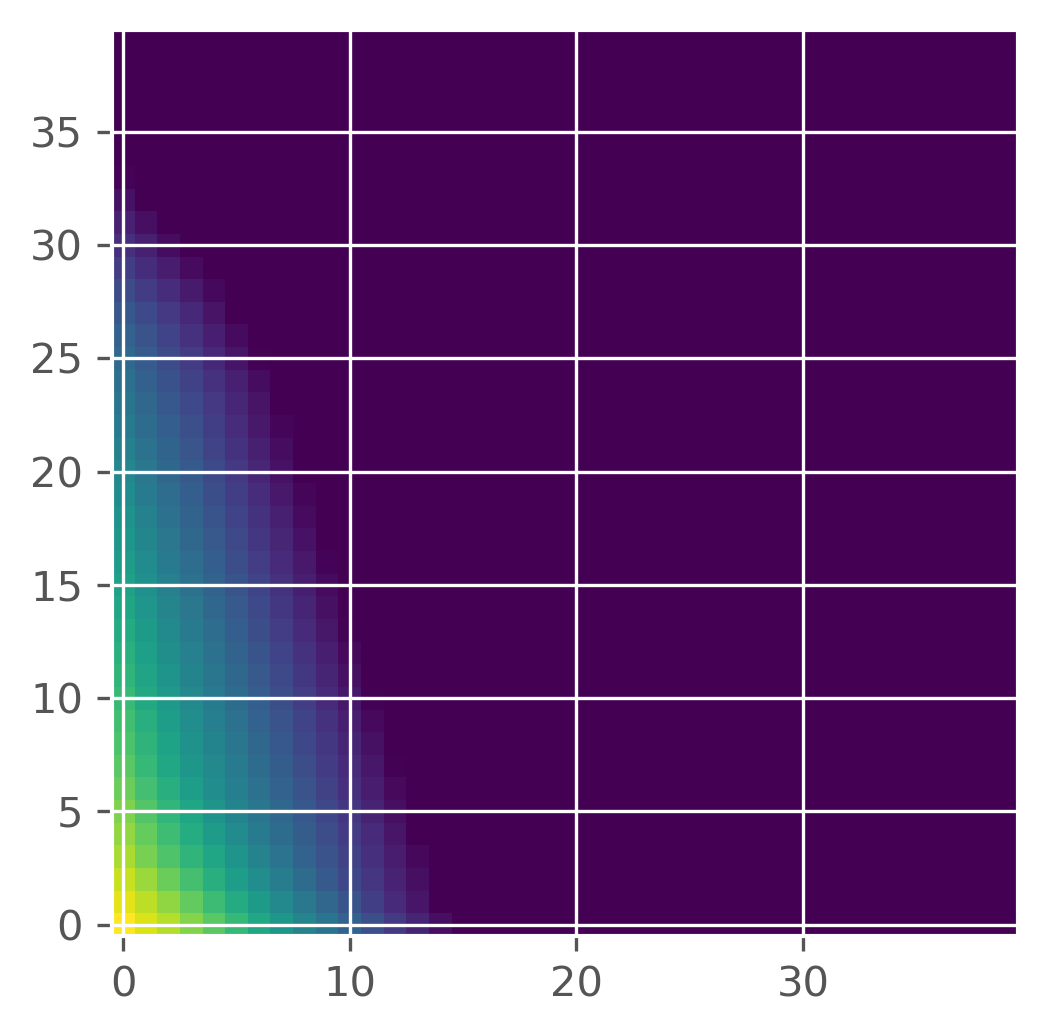

In [167]:
def make_batch():
    global batchsize

    inputs=random.uniform(low=-0.5,high=+0.5,size=[batchsize,2])
    targets=zeros([batchsize,1]) # must have right dimensions
    targets[:,0]=my_target(inputs[:,0],inputs[:,1])
    return(inputs,targets)
    
# try to evaluate the (randomly initialized) network
# on some area in the 2D plane
test_batchsize=shape(X0)[0]*shape(X0)[1]
testsample=zeros([test_batchsize,2])
testsample[:,0]=X0.flatten()
testsample[:,1]=X1.flatten()

testoutput=apply_net_simple(testsample)
myim=plt.imshow(reshape(testoutput,shape(X0)),origin='lower',interpolation='none')
plt.show()

C:\Users\erick\AppData\Local\Temp\ipykernel_13668\3789948565.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  targets[:,0]=my_target(inputs[:,0],inputs[:,1])


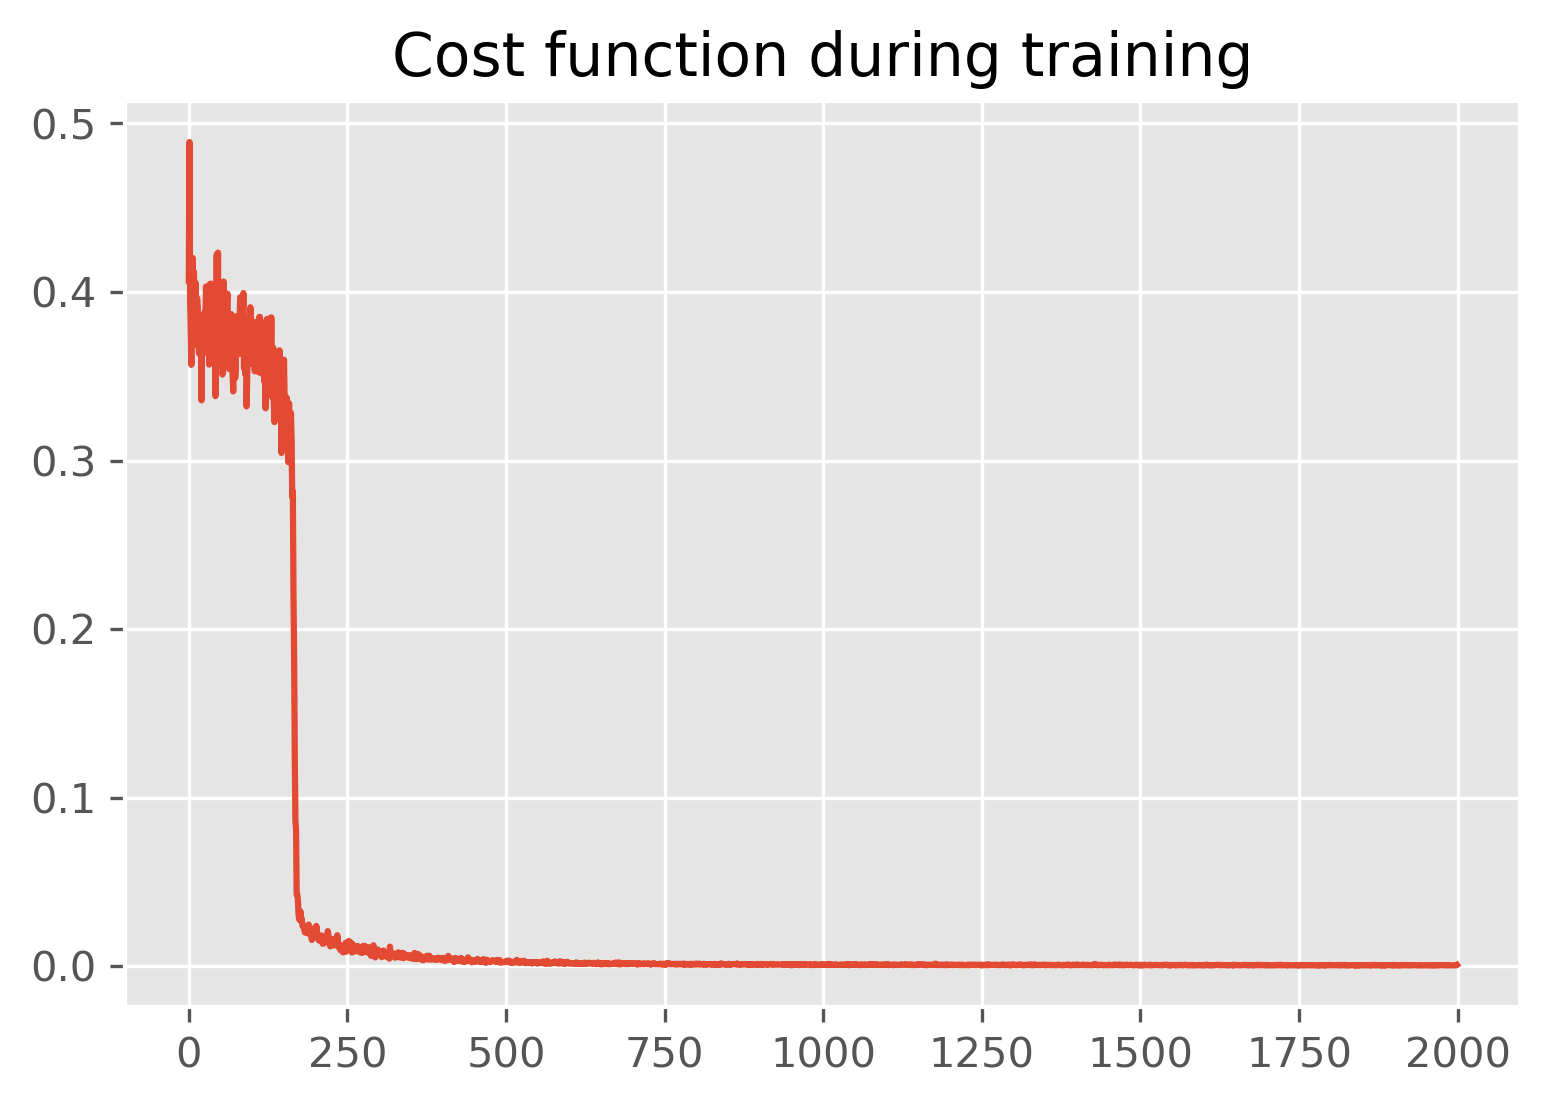

In [169]:
# now train on randomly sampled points
# to make the network reproduce better and
# better this 2D function!
eta=.001
batches=2000
costs=zeros(batches)

for k in range(batches):
    y_in,y_target=make_batch()
    costs[k]=train_net(y_in,y_target,eta)

plt.plot(costs)
plt.title("Cost function during training")
plt.show()

#### Animate the network results during training

In [170]:
# start fresh:

# set up all the weights and biases

NumLayers=2 # does not count input-layer (but does count output)
LayerSizes=[2,100,1] # input-layer,hidden-1,hidden-2,...,output-layer

Weights=[random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NumLayers)]
Biases=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

# set up all the helper variables

y_layer=[zeros(LayerSizes[j]) for j in range(NumLayers+1)]
df_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]
dw_layer=[zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
db_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

C:\Users\erick\AppData\Local\Temp\ipykernel_13668\3789948565.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  targets[:,0]=my_target(inputs[:,0],inputs[:,1])


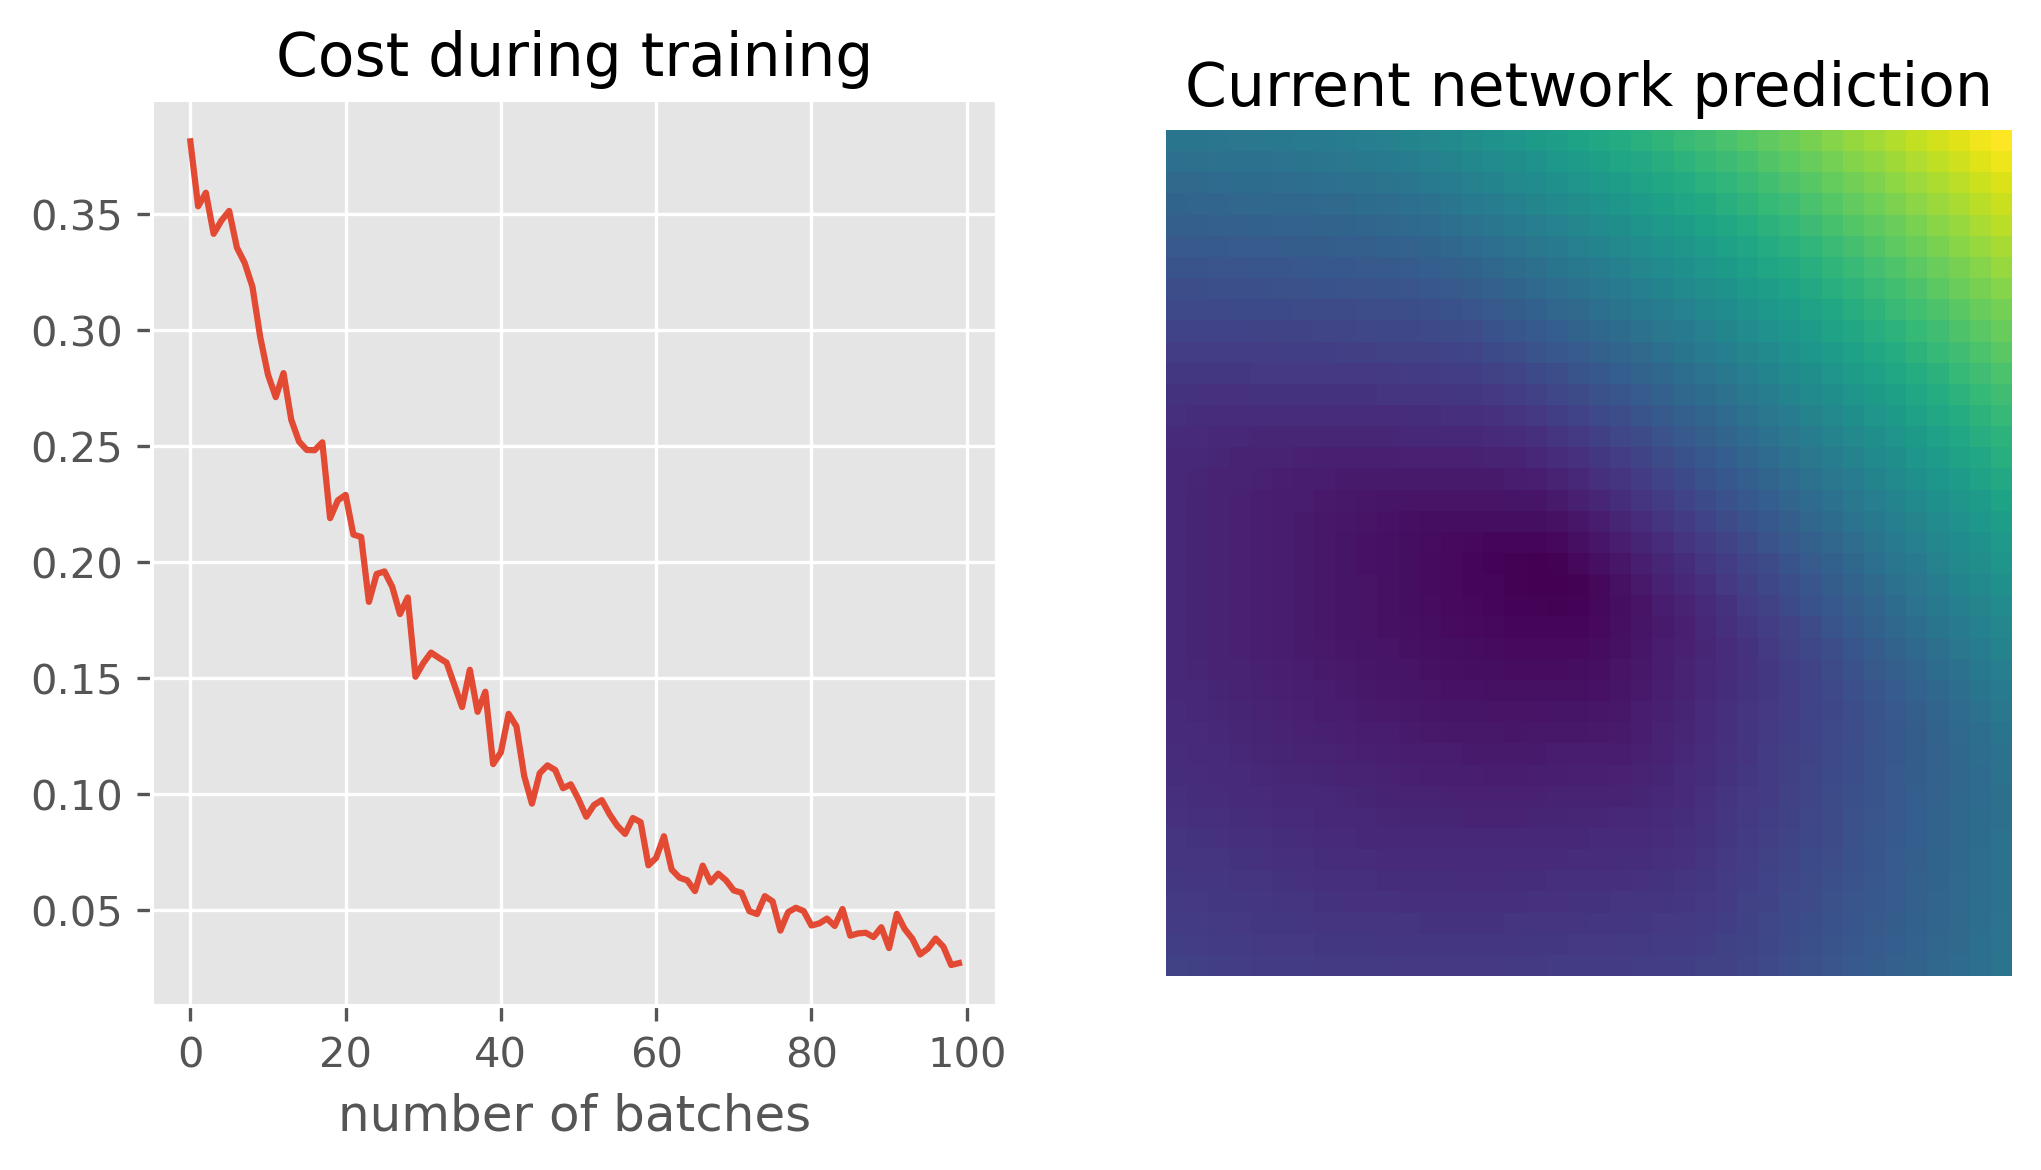

In [171]:
eta=0.01 # learning rate
nsteps=100

costs=zeros(nsteps)
for j in range(nsteps):
    clear_output(wait=True)
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(8,4)) # prepare figure
    ax[1].axis('off') # no axes
    
    # the crucial lines:
    y_in,y_target=make_batch() # random samples (points in 2D)
    costs[j]=train_net(y_in,y_target,eta) # train network (one step, on this batch)
    testoutput=apply_net_simple(testsample) # check the new network output in the plane
    
    img=ax[1].imshow(reshape(testoutput,shape(X0)),interpolation='nearest',origin='lower') # plot image
    ax[0].plot(costs)
    
    ax[0].set_title("Cost during training")
    ax[0].set_xlabel("number of batches")
    ax[1].set_title("Current network prediction")
    plt.show()
    sleep(0.1)

### NN Structure with Keras

c:\Users\erick\anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


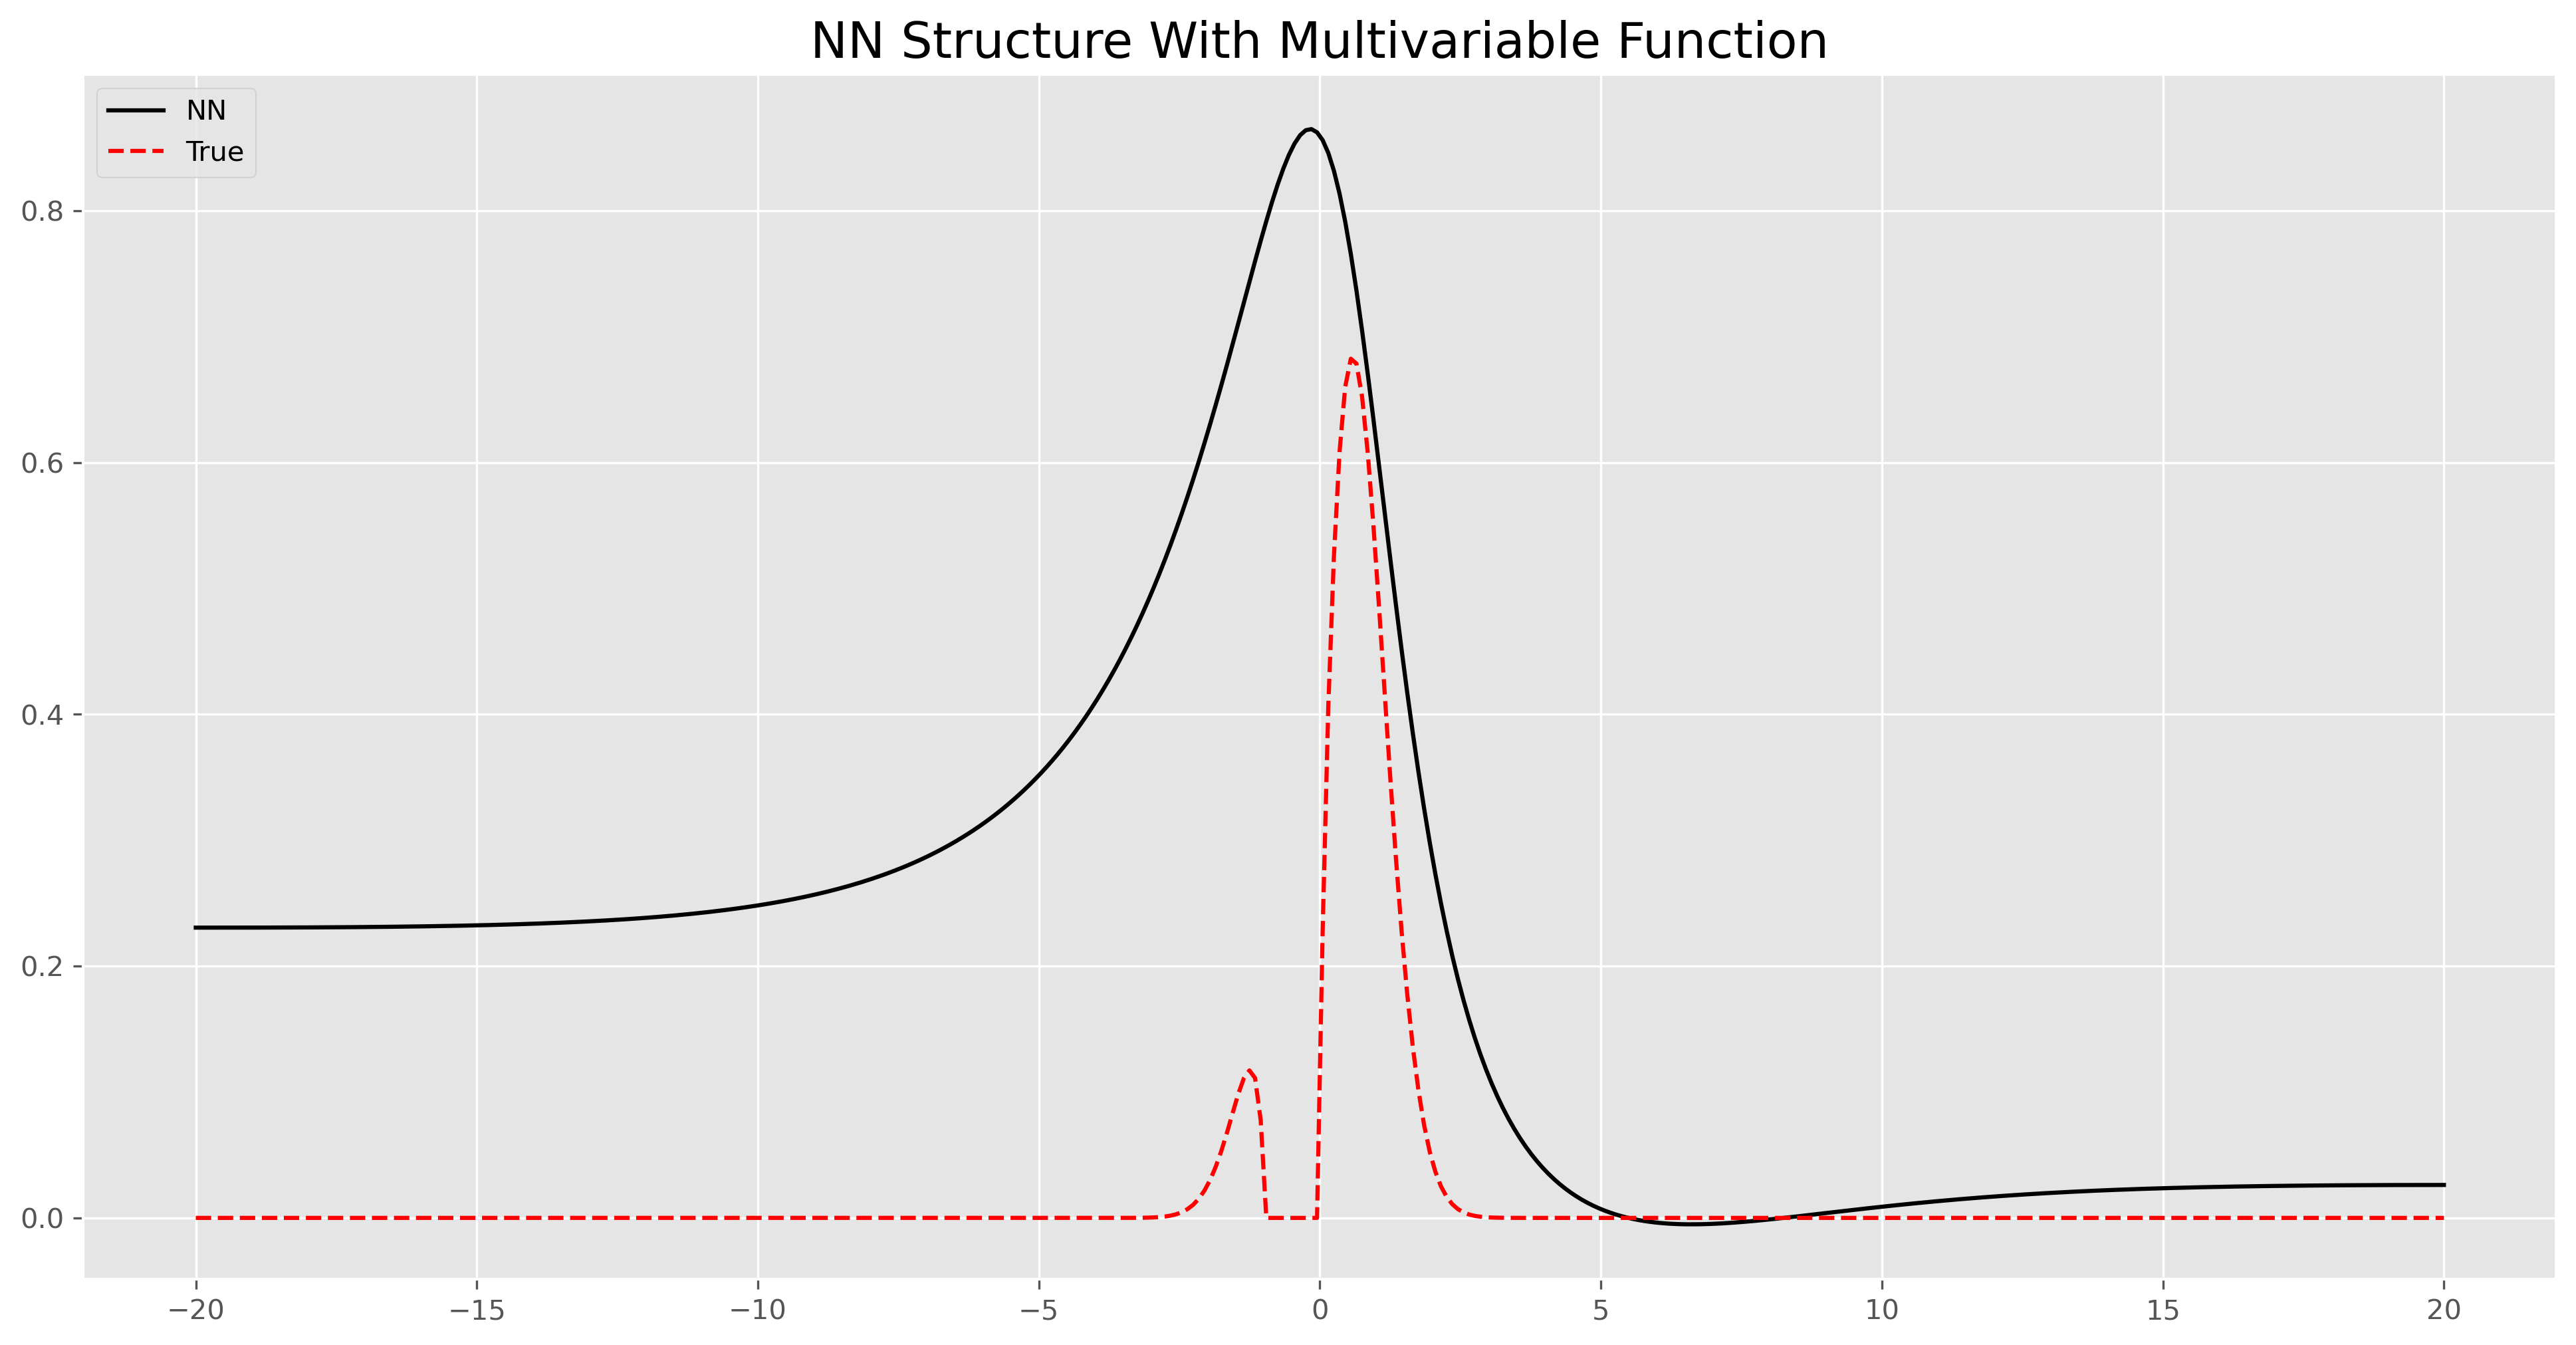

In [128]:
Net=Sequential() 
Net.add(Dense(20,input_shape=(1,),activation="sigmoid")) 
Net.add(Dense(10,activation="sigmoid")) 
Net.add(Dense(1,activation="linear")) 

Net.compile(loss='mean_squared_error',
              optimizer='adam') 

def my_target(x):
    exp_x = -(x[1]**2)
    new_x = x[0]**2 + x[1]
    return( np.exp(exp_x)*np.sqrt(new_x + 0j) )

training_batches=1000 
batchsize=20 
costs=np.zeros((2,training_batches))

x0 = np.random.uniform(low=-10.0,high=+10.0,size=[batchsize,1])
x1 = np.random.uniform(low=-10.0,high=+10.0,size=[batchsize,1])
x = np.array((x0,x1))
y_target = my_target(x)

for i in range(len(x)):
    for j in range(training_batches):
        costs[i][j] = Net.train_on_batch(x[i], y_target)
        print(str(costs[i][j]),end="   \r") 
N=400 
y_in=np.zeros([2,N])
y_in[0]=np.linspace(-20.0,20.0,N)
y_in[1]=np.linspace(-20.0,20.0,N) 
y_0=Net.predict_on_batch(y_in[0])

plt.style.use('ggplot')
plt.figure(figsize = (16, 8))
plt.title('NN Structure With Multivariable Function', size=18)
plt.plot(y_in[0], y_0, 'k', label=r"NN")
plt.plot(y_in[0], my_target(y_in), 'r--', label=r"True")
plt.legend(loc = "upper left")
plt.show()